# Import Model

In [1]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, negative_slope=0.01):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.LeakyReLU(negative_slope)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.shortcut = None
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.relu2 = nn.LeakyReLU(negative_slope)

    def forward(self, x):
        identity = x
        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.shortcut is not None:
            identity = self.shortcut(x)
        out += identity
        return self.relu2(out)


class DeepTileEncoder(nn.Module):
    """加深的 Tile 分支：全局信息，多尺度池化 + 三层 MLP"""
    def __init__(self, out_dim, in_channels=3, negative_slope=0.01):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope),
            nn.MaxPool2d(2)  # 78→39
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64, negative_slope=negative_slope),
            ResidualBlock(64, 64, negative_slope=negative_slope),
            nn.MaxPool2d(2)  # 39→19
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128, negative_slope=negative_slope),
            ResidualBlock(128, 128, negative_slope=negative_slope),
            nn.MaxPool2d(2)  # 19→9
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(128, 256, negative_slope=negative_slope),
            ResidualBlock(256, 256, negative_slope=negative_slope)
        )  # 保持 9×9

        # 多尺度池化
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # [B,256,1,1]
        self.mid_pool    = nn.AdaptiveAvgPool2d((3, 3))  # [B,256,3,3]

        total_dim = 256*1*1 + 256*3*3
        # 三层 MLP：total_dim → 2*out_dim → out_dim → out_dim
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),
            nn.Linear(total_dim, out_dim*4),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*4, out_dim*2),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*2, out_dim),
            nn.LeakyReLU(negative_slope),
        )

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x: [B,256,9,9]
        g = self.global_pool(x).contiguous().reshape(x.size(0), -1)  # [B,256]
        m = self.mid_pool(x).contiguous().reshape(x.size(0), -1)     # [B,256*3*3]
        return self.fc(torch.cat([g, m], dim=1))


class SubtileEncoder(nn.Module):
    """多尺度 Subtile 分支：局部信息 + 两层 MLP"""
    def __init__(self, out_dim, in_channels=3, negative_slope=0.01):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope),
            nn.MaxPool2d(2)  # 26→13
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64, negative_slope=negative_slope),
            ResidualBlock(64, 64, negative_slope=negative_slope),
            nn.MaxPool2d(2)  # 13→6
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128, negative_slope=negative_slope),
            ResidualBlock(128, 128, negative_slope=negative_slope)
        )  # 保持 6×6

        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.mid_pool    = nn.AdaptiveAvgPool2d((2,2))
        total_dim = 128*1*1 + 128*2*2
        # 两层 MLP：total_dim → out_dim*2 → out_dim
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),
            nn.Linear(total_dim, out_dim*2),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*2, out_dim),
            nn.LeakyReLU(negative_slope),
        )

    def forward(self, x):
        B, N, C, H, W = x.shape
        x = x.contiguous().reshape(B*N, C, H, W)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        # g,m: [B*N, feat]
        g = self.global_pool(x).contiguous().reshape(B, N, -1)
        m = self.mid_pool(x).contiguous().reshape(B, N, -1)
        # 合并 N 张 subtiles，再 FC
        feat = torch.cat([g, m], dim=2).mean(dim=1)  # [B, total_dim]
        return self.fc(feat)


class VisionMLP_MultiTask(nn.Module):
    """整体多任务模型：融合全局 Tile 与局部 Subtile 信息"""
    def __init__(self, tile_dim=64, subtile_dim=64, output_dim=35):
        super().__init__()
        self.encoder_tile    = DeepTileEncoder(tile_dim)
        self.encoder_subtile = SubtileEncoder(subtile_dim)
        self.decoder = nn.Sequential(
            nn.Linear(tile_dim + subtile_dim, 128),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.1),
            nn.Linear(128, output_dim),
        )

    def forward(self, tile, subtiles):
        # tile: [B,3,78,78]
        f_tile = self.encoder_tile(tile)
        # subtiles: [B,9,3,26,26]
        f_sub  = self.encoder_subtile(subtiles)
        x = torch.cat([f_tile, f_sub], dim=1)
        return self.decoder(x)


# 用法示例
model = VisionMLP_MultiTask(tile_dim=64, subtile_dim=64, output_dim=35)

## Load Model

# Import training data

## Same in multiple .pt

In [2]:
import os
import torch
import random
import inspect
from python_scripts.import_data import load_all_tile_data

# 用法範例
folder = "dataset/spot-rank/realign/version-1/only_tile_sub/train_8x/"
grouped_data = load_all_tile_data( 
        folder_path=folder,
        model=model,
        fraction=1,
        shuffle=False
    )

    # grouped_data 現在只會有 model.forward() 需要的 key，
    # 像 ['tile','subtiles','neighbors','norm_coord','node_feat','adj_list','edge_feat','label','source_idx']
print("Loaded keys:", grouped_data.keys())
print("Samples:", len(next(iter(grouped_data.values()))))


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spatialhackathon

Loaded keys: dict_keys(['slide_idx', 'tile', 'subtiles', 'label', 'source_idx'])
Samples: 75132


In [3]:
import os
import torch
import csv
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from python_scripts.operate_model import train_one_epoch, evaluate, predict, EarlyStopping, plot_losses, plot_per_cell_metrics
import torch.nn as nn

# ---------------------------
# 指定儲存資料夾
# ---------------------------
save_folder = "/Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/CNN+Res+MLP_version-1/softrank/no_coords_neighbor/k-fold_v2/"  # 修改為你想要的資料夾名稱
if not os.path.exists(save_folder):
    os.makedirs(save_folder)


In [4]:
# --------------------------------------------
# 2) 從 grouped_data 取出 slide_idx，轉成 numpy
# --------------------------------------------
import numpy as np
slide_idx = np.array(grouped_data['slide_idx'])   # shape (N,)

# --------------------------------------------
# 3) 建立 LOGO（或改成 GroupKFold）
# --------------------------------------------
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()

# X 可以給虛擬矩陣，因為分組只靠 groups
X_dummy = np.zeros(len(slide_idx))
X_dummy

array([0., 0., 0., ..., 0., 0., 0.])

Epoch 14/150 | loss: 15.8030 | val_loss: 19.9186 | lr: 1.00e-05
train spearman: 0.9210 | Val spearman: 0.9047 | best: 0.9168


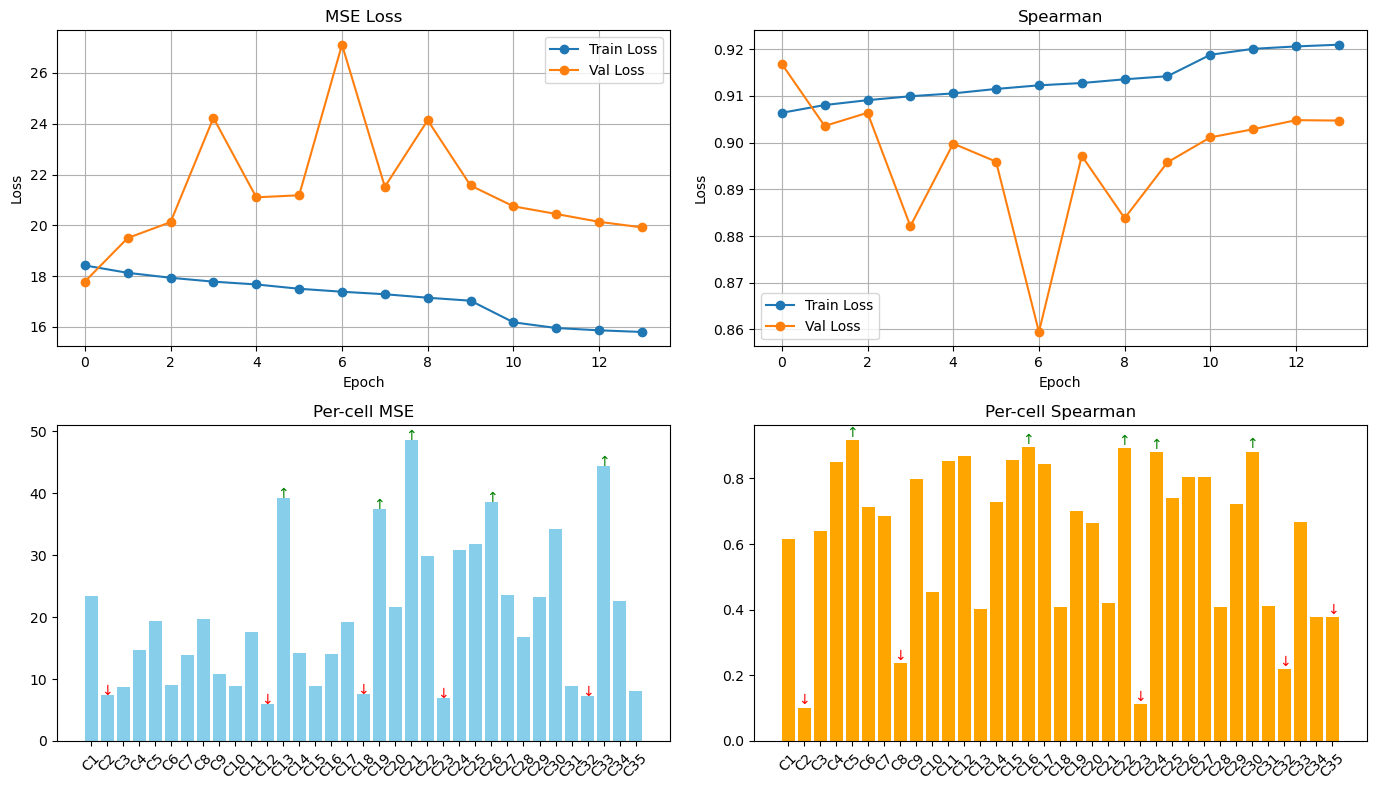

<Figure size 640x480 with 0 Axes>

曲線圖已儲存至 /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/CNN+Res+MLP_version-1/softrank/no_coords_neighbor/k-fold_v2/fold5/loss_curve.png
⛔ early stop
📈 Fold 5 best ρ = 0.9168

=========== CV summary ===========
fold 0: best ρ = 0.6378
fold 1: best ρ = 0.7437
fold 2: best ρ = 0.8757
fold 3: best ρ = 0.8787
fold 4: best ρ = 0.8892
fold 5: best ρ = 0.9168
overall best (mean) ρ = 0.8237 ± 0.0997


In [5]:
from torch.utils.data import DataLoader, Subset
from python_scripts.import_data import importDataset

# ---------------- 基本參數 ----------------
BATCH_SIZE   = 32
num_epochs   = 150
save_root    = save_folder          # 最外層
os.makedirs(save_root, exist_ok=True)

# ------------- 整批 Dataset -------------
full_dataset = importDataset(grouped_data, model,
                             image_keys=['tile','subtiles'],
                             transform=lambda x: x)

logo     = LeaveOneGroupOut()
device   = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("✅ device:", device)

overall_best = []

# ➋ LOGO / GroupKFold 切分索引，對 Dataset 建 Subset
for fold_id, (tr_idx, va_idx) in enumerate(
        logo.split(X=np.zeros(len(slide_idx)), y=None, groups=slide_idx)):

    # ----- DataLoader -----
    train_loader = DataLoader(Subset(full_dataset, tr_idx),
                              batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(Subset(full_dataset, va_idx),
                              batch_size=BATCH_SIZE, shuffle=False)

    # ----- 新建模型 / 優化器 -----
    net       = model.to(device)               # ← 若 model 是 class，請改成 model() 重新初始化
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',          # 監控 loss
        factor=0.1,          # 每次衰減 10×
        patience=8,          # 5 個 epoch 沒進步才降
        cooldown=1,          # 降完等 1 個 epoch 再觀察
        min_lr=1e-6,         # 不要降過頭
        verbose=True
    )
    stopper   = EarlyStopping(patience=13)

    # ----- fold 專屬輸出路徑 -----
    fold_dir  = os.path.join(save_folder, f"fold{fold_id}")
    os.makedirs(fold_dir, exist_ok=True)
    best_model_path = os.path.join(fold_dir, "best_model.pt")
    loss_plot_path  = os.path.join(fold_dir, "loss_curve.png")
    csv_path        = os.path.join(fold_dir, "training_log.csv")

    # ----- CSV log -----
    log_f = open(csv_path, "w", newline="")
    csv_w = csv.writer(log_f)
    csv_w.writerow(["Epoch","TrainLoss","ValLoss","ValSpearman","LR"])

    # ----- 圖形 -----
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    display(fig)

    train_losses = []; val_losses = []
    train_rhos   = []; val_rhos   = []

    best_rho = -1.0

    for epoch in range(num_epochs):
        tloss, trho = train_one_epoch(
            net, train_loader, optimizer, device,
            kappa = 100,
            current_epoch=epoch, initial_alpha=0, final_alpha=0, target_epoch=1)

        vloss, vrho, mse_cell, rho_cell = evaluate(
            net, val_loader, device,
            kappa = 100,
            current_epoch=epoch, initial_alpha=0, final_alpha=0, target_epoch=1)

        clear_output(wait=True)  # 清除之前的輸出
        axes[0][0].clear()
        axes[0][1].clear()
        axes[1][0].clear()
        axes[1][1].clear()
        # --- save best ---
        if vrho > best_rho:
            best_rho = vrho
            torch.save(net.state_dict(), best_model_path)
            print(f"✅ Saved best model in {best_model_path}!")

        # --- scheduler / early stop ---
        scheduler.step(vloss); stopper(vloss)


    
        # --- logging ---
        lr = optimizer.param_groups[0]['lr']
        csv_w.writerow([epoch+1, tloss, vloss, vrho, lr])

        train_losses.append(tloss); val_losses.append(vloss)
        train_rhos.append(trho);   val_rhos.append(vrho)
        

        

        # 印出 Epoch 結果
        print(f"Epoch {epoch + 1}/{num_epochs} | loss: {tloss:.4f} | val_loss: {vloss:.4f} | lr: {lr:.2e}")
        print(f"train spearman: {trho:.4f} | Val spearman: {vrho:.4f} | best: {best_rho:.4f}")
        # --- update plots ---
        plot_losses(train_losses, val_losses, axes[0][0], "MSE Loss")
        plot_losses(train_rhos,   val_rhos,   axes[0][1], "Spearman")
        cell_names = [f"C{i+1}" for i in range(35)]
        plot_per_cell_metrics(mse_cell, rho_cell, cell_names,
                              ax_mse=axes[1][0], ax_spearman=axes[1][1])
        plt.tight_layout(); display(fig); plt.pause(0.1)
        fig.savefig(loss_plot_path)
        print(f"曲線圖已儲存至 {loss_plot_path}")
        if stopper.early_stop:
            print("⛔ early stop"); break

    log_f.close(); plt.close(fig)
    overall_best.append(best_rho)
    print(f"📈 Fold {fold_id} best ρ = {best_rho:.4f}")

# ========= 整體結果 =========
overall_best = np.array(overall_best)
print("\n=========== CV summary ===========")
for i, r in enumerate(overall_best):
    print(f"fold {i}: best ρ = {r:.4f}")
print(f"overall best (mean) ρ = {overall_best.mean():.4f} ± {overall_best.std():.4f}")

# Predict

In [6]:
import torch
import inspect
from python_scripts.operate_model import get_model_inputs

def load_node_feature_data(pt_path: str, model, num_cells: int = 35) -> dict:
    """
    根据 model.forward 的参数自动加载 .pt 里对应的字段，
    并且如果没有 label，就自动创建一个全 0 的 label 张量，
    其尺寸为 (样本数, num_cells)，样本数从第一个有 __len__ 的输入推断。

    参数：
      pt_path:     str，.pt 文件路径
      model:       已实例化的 PyTorch 模型
      num_cells:   int，label 的列数（默认 35）

    返回：
      dict: key 对应模型 forward 中的参数名（不含 self），
            value 是对应的 Tensor/ndarray，
            并额外保证有 'label' 字段。
    """
    # 1) 载入原始数据
    raw = torch.load(pt_path, map_location="cpu")

    # 2) 取模型 forward 入参签名（不含 self）
    sig = inspect.signature(model.forward)
    param_names = [p for p in sig.parameters if p != "self"]

    out = {}
    for name in param_names:
        # a) 直接同名
        if name in raw:
            out[name] = raw[name]
            continue
        # b) 复数形式
        if name + "s" in raw:
            out[name] = raw[name + "s"]
            continue
        # c) 模糊匹配（下划线、复数或前后缀）
        cands = [k for k in raw if name in k or k in name]
        if len(cands) == 1:
            out[name] = raw[cands[0]]
            continue
        raise KeyError(f"无法找到 '{name}' 在 pt 文件中的对应字段，raw keys: {list(raw.keys())}")

    # 3) 用第一个支持 len() 的输入推断样本数
    dataset_size = None
    for v in out.keys():
        if hasattr(out[v], "__len__"):
            dataset_size = len(out[v])
            print(f"⚠️ 从 '{v}' 推断样本数量: {dataset_size}")
            break
    if dataset_size is None:
        raise RuntimeError("无法从任何输入中推断样本数量，请检查 pt 文件内容。")

    # 4) 自动补 label

    out["label"] = torch.zeros((dataset_size, num_cells), dtype=torch.float32)
    return out


image_keys = [ 'tile', 'subtiles']


# 用法示例
from python_scripts.import_data import importDataset
# 假设你的 model 已经定义好并实例化为 `model`
test_dataset = load_node_feature_data("dataset/spot-rank/version-1/only_tile_sub/test/test_dataset.pt", model)
test_dataset = importDataset(
        data_dict=test_dataset,
        model=model,
        image_keys=image_keys,
        transform=lambda x: x,  # identity transform
        print_sig=True
    )



/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_98895/333364545.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(pt_path, map_location="cpu")

⚠️ 从 'tile' 推断样本数量: 2088
Model forward signature: (tile, subtiles)


In [20]:

test_dataset.check_item(1000, 10)


🔍 Checking dataset sample: 1000
📏 tile shape: torch.Size([3, 78, 78]) | dtype: torch.float32 | min: 0.200, max: 1.000, mean: 0.729, std: 0.152
📏 subtiles shape: torch.Size([9, 3, 26, 26]) | dtype: torch.float32 | min: 0.200, max: 1.000, mean: 0.729, std: 0.152
📏 label shape: torch.Size([35]) | dtype: torch.float32 | min: 0.000, max: 0.000, mean: 0.000, std: 0.000
--- label head (前 10 個元素):
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
✅ All checks passed!


In [7]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
import glob
import torch
import numpy as np
import pandas as pd
import os
import h5py
from torch.utils.data import DataLoader

# 讀 test spot index
with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spots     = f["spots/Test"]
    test_spot_table= pd.DataFrame(np.array(test_spots['S_7']))

fold_ckpts = sorted(glob.glob(os.path.join(save_folder, "fold*", "best_model.pt")))
models = []
for ckpt in fold_ckpts:
    net = VisionMLP_MultiTask(tile_dim=64, subtile_dim=64, output_dim=35)
    net.load_state_dict(torch.load(ckpt, map_location="cpu"))
    net.to(device).eval()
    models.append(net)

all_fold_preds = []
for fold_id, net in enumerate(models):
    # 推論
    with torch.no_grad():
        preds = predict(net, test_loader, device)  # (N_test,35) numpy array

    # 1) 存每一折的原始預測
    df_fold = pd.DataFrame(preds, columns=[f"C{i+1}" for i in range(preds.shape[1])])
    df_fold.insert(0, "ID", test_spot_table.index)
    path_fold = os.path.join(save_folder, f"submission_fold{fold_id}.csv")
    df_fold.to_csv(path_fold, index=False)
    print(f"✅ Saved fold {fold_id} predictions to {path_fold}")

    all_fold_preds.append(preds)

# 2) 做 rank‐average ensemble
all_fold_preds = np.stack(all_fold_preds, axis=0)       # (K, N_test, 35)
ranks          = all_fold_preds.argsort(axis=2).argsort(axis=2).astype(float)
mean_rank      = ranks.mean(axis=0)                    # (N_test,35)

# 3) 存 final ensemble
df_ens = pd.DataFrame(mean_rank, columns=[f"C{i+1}" for i in range(mean_rank.shape[1])])
df_ens.insert(0, "ID", test_spot_table.index)
path_ens = os.path.join(save_folder, "submission_rank_ensemble.csv")
df_ens.to_csv(path_ens, index=False)
print(f"✅ Saved rank‐ensemble submission to {path_ens}")


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_98895/2447089009.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(ckpt, map_loc

✅ Saved fold 0 predictions to /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/CNN+Res+MLP_version-1/softrank/no_coords_neighbor/k-fold_v2/submission_fold0.csv
✅ Saved fold 1 predictions to /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/CNN+Res+MLP_version-1/softrank/no_coords_neighbor/k-fold_v2/submission_fold1.csv
✅ Saved fold 2 predictions to /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/CNN+Res+MLP_version-1/softrank/no_coords_neighbor/k-fold_v2/submission_fold2.csv
✅ Saved fold 3 predictions to /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/CNN+Res+MLP_version-1/softrank/no_coords_neighbor/k-fold_v2/submission_fold3.csv
✅ Saved fold 4 predictions to /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/CNN+Res+MLP_version-1/softrank/no_coords_neighbor/k-fold_v2/submission_fold4.csv
✅ Saved fold 5 predictions to /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/r